In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cc_df = pd.read_csv("../Data/creditcard.csv").rename({"Class": "Fraud_Flag"}, axis=1)

cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud_Flag
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split


X = pd.get_dummies(cc_df.iloc[:, 1:30], dtype="int", drop_first=True)
y = cc_df["Fraud_Flag"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [3]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

lr = logreg.fit(X_train, y_train)

print(f"Train Accuracy: {lr.score(X_train, y_train)}")
print(f"Test Accuracy: {lr.score(X_test, y_test)}")

Train Accuracy: 0.9992099892470758
Test Accuracy: 0.9991397773954567


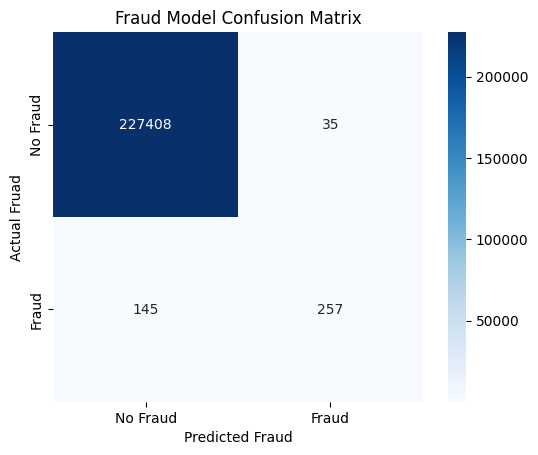

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_train)

knn_confusion = confusion_matrix(y_train, y_pred)

sns.heatmap(
    knn_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["No Fraud", "Fraud"],        
    yticklabels=["No Fraud", "Fraud"]
).set(
    xlabel='Predicted Fraud',
    ylabel='Actual Fruad',
    title='Fraud Model Confusion Matrix'
);

In [5]:
#!pip install imbalanced-learn

In [6]:
import imblearn.over_sampling as OS

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# create 4x as many positive samples
ratio = {1 : n_pos * 4, 0 : n_neg}

# randomly oversample positives
ROS = OS.RandomOverSampler(
    sampling_strategy = ratio,
    random_state=2023
)

X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

print(f"Original Positive Class Count: {np.sum(y_train)}")
print(f"Oversample Positive Class Count: {np.sum(y_train_rs)}")

Original Positive Class Count: 402
Oversample Positive Class Count: 1608


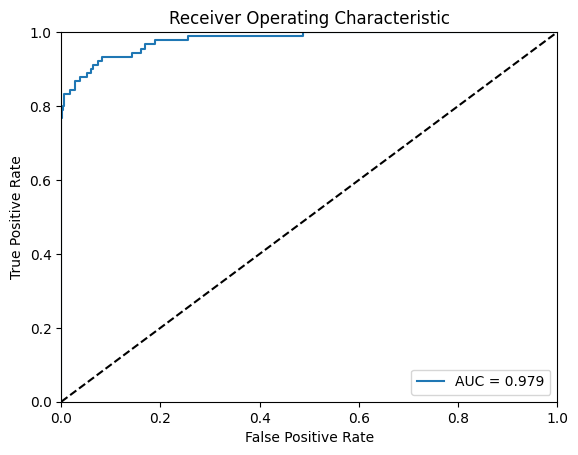

In [7]:
lr.fit(X_train_rs, y_train_rs)


from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--', label="Random Guess")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
from sklearn.metrics import f1_score

lr.fit(X_train_rs, y_train_rs)

print(f"Oversampled Test F1: {f1_score(y_test, lr.predict(X_test))}")

Oversampled Test F1: 0.7570621468926554


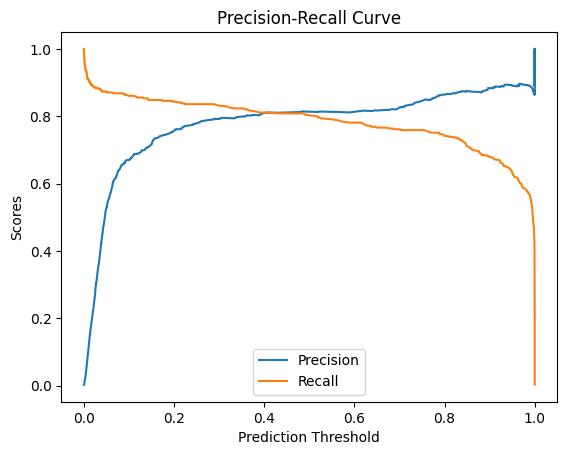

In [9]:
from sklearn.metrics import precision_recall_curve

p_curve, r_curve, t_curve = precision_recall_curve(y_train, lr.predict_proba(X_train)[:,1])

# p_r_curve = pd.DataFrame({"precision": p_curve, "recall": r_curve, "threshold": t_curve})
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision-Recall Curve')
# plt.grid(True)
plt.show()

In [10]:
print(f"Oversampled Test F1: {f1_score(y_test, lr.predict_proba(X_test)[:, 1] > .8)}")

Oversampled Test F1: 0.7590361445783133


In [11]:
import imblearn.over_sampling

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# create 4x as many positive samples
ratio = {1 : n_pos * 16, 0 : n_neg}

# SMOTE oversampling for positives
smt = OS.SMOTE(
    sampling_strategy = ratio,
    random_state=2023
)

X_train_rs, y_train_rs = smt.fit_resample(X_train, y_train)


print(f"Original Positive Class Count: {np.sum(y_train)}")
print(f"Oversample Positive Class Count: {np.sum(y_train_rs)}")

c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Original Positive Class Count: 402
Oversample Positive Class Count: 6432


In [12]:
lr.fit(X_train_rs, y_train_rs)

#print(f"Oversampled Test F1: {f1_score(y_test, lr.predict(X_test))}")

LogisticRegression(max_iter=1000)

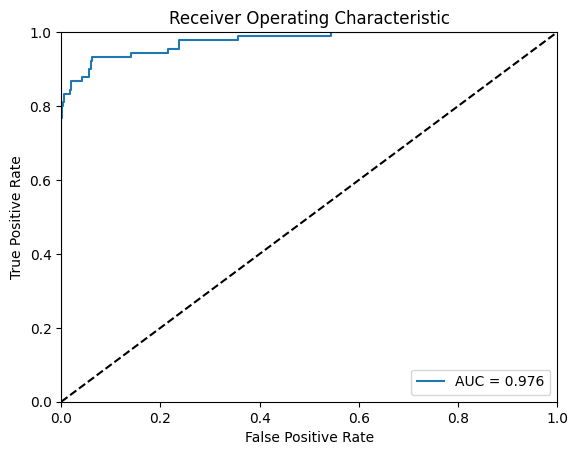

In [13]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--', label="Random Guess")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
import imblearn.under_sampling as US 

# Define Minority Class %
minority_pct = .01

# randomly undersample negative samples: 
RUS = US.RandomUnderSampler(
                   sampling_strategy = (minority_pct)/(1 - minority_pct),
                   random_state=2023
)

X_train_rs, y_train_rs = RUS.fit_resample(X_train, y_train)

print(f"Original Negative Class Count: {np.mean(y_train)}")
print(f"Undersample Negative Class Count: {np.mean(y_train_rs)}")

Original Negative Class Count: 0.0017643573481972393
Undersample Negative Class Count: 0.01


In [15]:
lr.fit(X_train_rs, y_train_rs)

print(f"Oversampled Test F1: {f1_score(y_test, lr.predict(X_test))}")

Oversampled Test F1: 0.7752808988764045


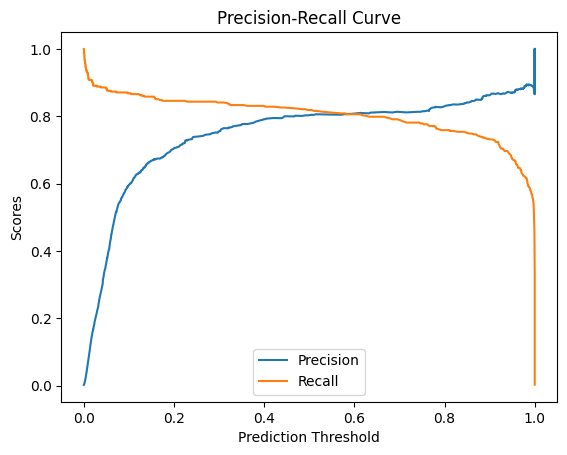

In [16]:
from sklearn.metrics import precision_recall_curve

p_curve, r_curve, t_curve = precision_recall_curve(y_train, lr.predict_proba(X_train)[:,1])

# p_r_curve = pd.DataFrame({"precision": p_curve, "recall": r_curve, "threshold": t_curve})
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision-Recall Curve')
# plt.grid(True)
plt.show()

In [17]:
print(f"Oversampled Test F1: {f1_score(y_test, lr.predict_proba(X_test)[:, 1] > .5)}")

Oversampled Test F1: 0.7752808988764045


In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

lr = logreg.fit(X_train, y_train)

print(f"Train Accuracy: {lr.score(X_train, y_train)}")
print(f"Test Accuracy: {lr.score(X_test, y_test)}")

print(f"Test f1: {f1_score(y_test, lr.predict(X_test))}")

Train Accuracy: 0.9992099892470758
Test Accuracy: 0.9991397773954567
Test f1: 0.6666666666666666


In [19]:
from sklearn.metrics import roc_curve, auc

y_probs = lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc_score = auc(fpr, tpr)

auc_score

0.9745344320970288

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight={1: 4, 0: 1})

lr_weighted = logreg.fit(X_train, y_train)

print(f"Train Accuracy: {lr_weighted.score(X_train, y_train)}")
print(f"Test Accuracy: {lr_weighted.score(X_test, y_test)}")

print(f"Test f1: {f1_score(y_test, lr_weighted.predict(X_test))}")

Train Accuracy: 0.9993372687572692
Test Accuracy: 0.9992451107756047
Test f1: 0.7570621468926554


In [21]:
from sklearn.metrics import roc_curve, auc

y_probs = lr_weighted.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc_score = auc(fpr, tpr)

auc_score

0.9796988559103484

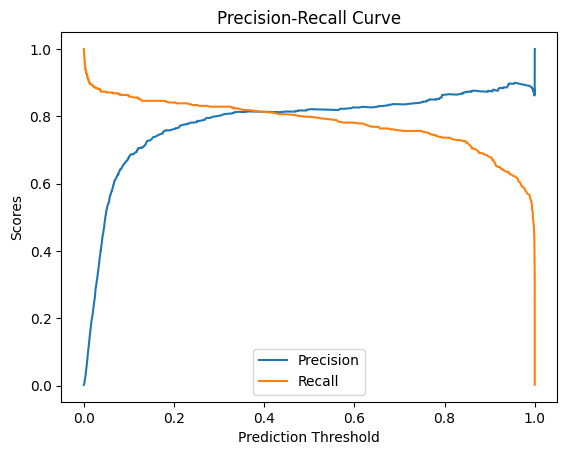

In [22]:
from sklearn.metrics import precision_recall_curve

p_curve, r_curve, t_curve = precision_recall_curve(y_train, lr_weighted.predict_proba(X_train)[:,1])

# p_r_curve = pd.DataFrame({"precision": p_curve, "recall": r_curve, "threshold": t_curve})
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision-Recall Curve')
# plt.grid(True)
plt.show()

In [23]:
print(f"Test f1: {f1_score(y_test, lr_weighted.predict_proba(X_test)[:, 1] > .35)}")

Test f1: 0.770949720670391
